In [25]:
import jupedsim as jps
from shapely import Polygon, Point
import pathlib
from typing import Tuple, List
import pedpy
import matplotlib.pyplot as plt
import numpy as np

In [26]:
eps = 0.01
area = Polygon(
    # complete area
    [
        (-12, -12),
        (12, -12),
        (12, 12),
        (-12, 12),
    ],
    holes=[
        [
            (-eps, 8 + eps),
            (eps, 8 - eps),
            (eps, 8 + eps),
            (-eps, 8 + eps),
        ],
        [
            (-eps, -8 + eps),
            (eps, -8 - eps),
            (eps, -8 + eps),
            (-eps, -8 + eps),
        ],
        [
            (-eps, -eps),
            (eps, -eps),
            (eps, eps),
            (-eps, eps),
        ],
        # left barrier
        [
            (-6, 10),
            (-6, 10.5),
            (-10.5, 10.5),
            (-10.5, -10.5),
            (-6, -10.5),
            (-6, -10),
            (-10, -10),
            (-10, 10),
        ],
        # right barrier
        [
            (6, 10),
            (6, 10.5),
            (10.5, 10.5),
            (10.5, -10.5),
            (6, -10.5),
            (6, -10),
            (10, -10),
            (10, 10),
        ],
        # top barrier
        [(-5, 10.5), (5, 10.5), (5, 10), (-5, 10)],
        # down barrier
        [(-5, -10.5), (5, -10.5), (5, -10), (-5, -10)],
    ],
)
walkable_area = pedpy.WalkableArea(area)

In [27]:
spawning_area = Polygon([(-8, -8), (8, -8), (8, 8), (-8, 8)])
num_agents = 100
pos_in_spawning_area = jps.distributions.distribute_by_number(
    polygon=spawning_area,
    number_of_agents=num_agents,
    distance_to_agents=0.5,
    distance_to_polygon=0.2,
    seed=1,
)
exit_areas = [
    Polygon(
        # door1
        [
            (-6, 10.6),
            (-5, 10.6),
            (-5, 10.9),
            (-6, 10.9),
        ],
    ),
    Polygon(
        # door2
        [
            (6, 10.6),
            (5, 10.6),
            (5, 10.9),
            (6, 10.9),
        ],
    ),
    Polygon(
        # door3
        [
            (-6, -10.6),
            (-5, -10.6),
            (-5, -10.9),
            (-6, -10.9),
        ],
    ),
    Polygon(
        # door4
        [
            (6, -10.6),
            (5, -10.6),
            (5, -10.9),
            (6, -10.9),
        ],
    ),
]

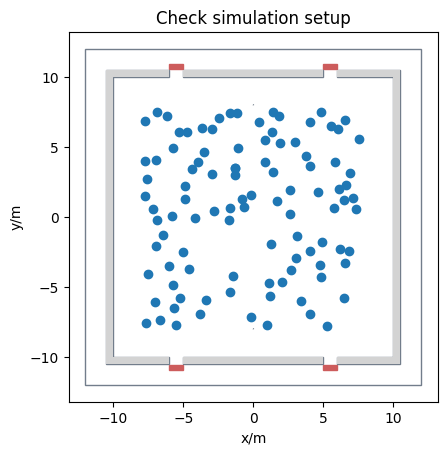

In [28]:
def plot_simulation_configuration(
    walkable_area: pedpy.WalkableArea,
    spawning_area: Polygon,
    starting_positions: Polygon,
    exit_areas: List[Polygon],
):
    axes = pedpy.plot_walkable_area(walkable_area=walkable_area)
    axes.fill(*spawning_area.exterior.xy, color="white")
    for exit_area in exit_areas:
        axes.fill(*exit_area.exterior.xy, color="indianred")

    axes.scatter(*starting_positions.exterior.xy)

    axes.set_title("Check simulation setup")
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")


plot_simulation_configuration(
    walkable_area, spawning_area, Polygon(pos_in_spawning_area), exit_areas
)

In [29]:
def get_nearest_exit_id(
    position: Point, exit_areas: List[Polygon], exit_ids: List[int]
) -> int:
    """Returns the nearest exit to the position."""
    min_distance = float("inf")
    selected_exit_id = None
    for i, exit_area in enumerate(exit_areas):
        distance = Point(position).distance(exit_area)
        if distance < min_distance:
            min_distance = distance
            selected_exit_id = exit_ids[i]

    return selected_exit_id

In [30]:
def run_simulation(num_exits: int, num_agents: int, seed:int = 1) -> Tuple[int, str]:
    """Create all simulation internals and initialise them with the input values.

    Returns evacuation time and trajectory name.
    """
    open_exit_areas = exit_areas[0:num_exits]  # selected the fist <num_exits>
    positions = jps.distributions.distribute_by_number(
        polygon=spawning_area,
        number_of_agents=num_agents,
        distance_to_agents=0.4,
        distance_to_polygon=0.35,
        seed=seed,
    )
    trajectory_file = f"traj_exits_{num_exits}_agents_{num_agents}.sqlite"
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(),
        dt=0.01,
        geometry=area,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file)
        ),
    )

    exit_ids = []
    for exit_area in open_exit_areas:
        exit_id = simulation.add_exit_stage(exit_area)
        exit_ids.append(exit_id)

    journey_id = simulation.add_journey(jps.JourneyDescription(exit_ids))

    for pos in positions:
        simulation.add_agent(
            jps.CollisionFreeSpeedModelAgentParameters(
                journey_id=journey_id,
                stage_id=get_nearest_exit_id(pos, open_exit_areas, exit_ids),
                position=pos,radius=0.15
            )
        )

    while simulation.agent_count() > 0:# and simulation.iteration_count() < 10000:
        simulation.iterate()

    print(f"{num_exits:<6} | {num_agents:<6} | {seed:<5} | {simulation.elapsed_time():.2f}")
    return simulation.elapsed_time(), trajectory_file

## Run simulations and analysis

The anticipated result is that the evacuation time with four open exits will be half that of an evacuation with only two open exits. This factor of 2, however, also hinges on the total number of agents involved in the simulation. Nevertheless, as the number of simulated agents grows, the factor should consistently approach 2, as illustrated in the plot.

Possible problems may be excessive clogging around doors, resulting from high densities.


Exits  | Agents | Seed  | Evac Time 
-----------------------------------
2      | 100    | 907   | 27.40
4      | 100    | 907   | 16.41
2      | 200    | 907   | 46.77
4      | 200    | 907   | 26.98
2      | 300    | 907   | 69.05
4      | 300    | 907   | 39.23
2      | 500    | 907   | 112.26
4      | 500    | 907   | 60.89
2      | 700    | 907   | 151.16
4      | 700    | 907   | 78.62
2      | 100    | 105   | 29.19
4      | 100    | 105   | 17.23
2      | 200    | 105   | 49.64
4      | 200    | 105   | 27.28
2      | 300    | 105   | 70.86
4      | 300    | 105   | 38.06
2      | 500    | 105   | 109.94
4      | 500    | 105   | 57.38
2      | 700    | 105   | 154.40
4      | 700    | 105   | 77.46


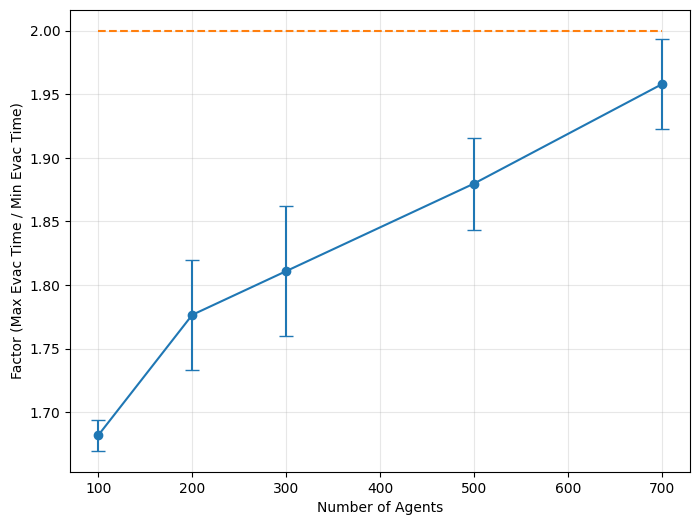

In [31]:
# Parameters
num_open_exits = [2, 4]
all_number_agents = [100, 200, 300, 500, 700]#, 900, 1000]
seeds = np.random.randint(0, 1000, 2)

# Placeholder for storing factors for all seeds
factors_all_seeds = {num_agents: [] for num_agents in all_number_agents}
print(f"{'Exits':<6} | {'Agents':<6} | {'Seed':<5} | {'Evac Time':<10}")
print("-" * 35)    
for seed in seeds:
    for num_agents in all_number_agents:
        evac_times = []
        for num_exit in num_open_exits:
            evac_time, trajectory_file = run_simulation(num_exit, num_agents, seed=seed)
            evac_times.append(evac_time)
        
        factor = max(evac_times) / min(evac_times)
        factors_all_seeds[num_agents].append(factor)

# postprocessing the results
mean_factors = []
std_factors = []
for num_agents in all_number_agents:
    mean_factors.append(np.mean(factors_all_seeds[num_agents]))
    std_factors.append(np.std(factors_all_seeds[num_agents]))

plt.figure(figsize=(8, 6))
plt.errorbar(all_number_agents, mean_factors, yerr=std_factors, fmt='o-', capsize=5, label='Factors with error bars')
plt.plot([all_number_agents[0], all_number_agents[-1]], [2, 2], "--")
plt.xlabel('Number of Agents')
plt.ylabel('Factor (Max Evac Time / Min Evac Time)')

plt.grid(True, alpha=0.3)
plt.show()
